<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/experiments/Acc_Class_Data_3Classes_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [2]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


In [3]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/mfcc_wo_spanish/train', transform=data_transform)
  test_data = [] #test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Librosa_MFCC_Test_Class/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/mfcc_wo_spanish/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


In [5]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Preparing & Visualizing Dataset

(27, 3, 128, 192)


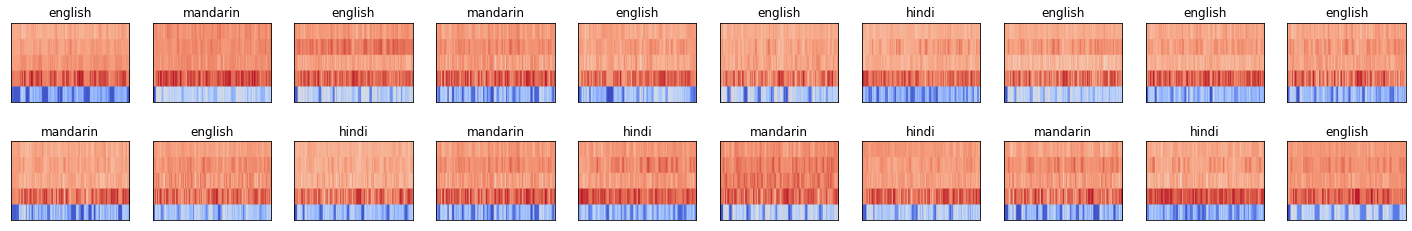

In [10]:
train_data, val_data, test_data= generate_data_image()
visualize_image_data(train_data)

In [11]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 310, 1: 280, 2: 440}


['english', 'india', 'mandarin']

## Accent Classifier Architecture


## Training 

In [10]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%25==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
          plot_graphs(iters, losses, [], train_acc, val_acc)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

## Baseline Experimentation with 3 classes, image size 128

In [16]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.1'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(30*46*64, 200)
          self.fc2 = nn.Linear(200, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 30*46*64)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.4097087378640777 Val Accuracy:  0.3181818181818182 Progress:   1.33  % Time Elapsed:  232.07 s 
Epoch 0 Finished.  Time per Epoch:  232.07 s 
Epoch:  1 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   2.67  % Time Elapsed:  283.22 s 
Epoch 1 Finished.  Time per Epoch:  141.61 s 
Epoch:  2 Train Accuracy:  0.4300970873786408 Val Accuracy:  0.3181818181818182 Progress:   4.00  % Time Elapsed:  334.35 s 
Epoch 2 Finished.  Time per Epoch:  111.45 s 
Epoch:  3 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   5.33  % Time Elapsed:  385.64 s 
Epoch 3 Finished.  Time per Epoch:  96.41 s 
Epoch:  4 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   6.67  % Time Elapsed:  436.90 s 
Epoch 4 Finished.  Time per Epoch:  87.38 s 
Epoch:  5 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   8.00  % Time Elapsed:  488.41 s 
Epoch 5

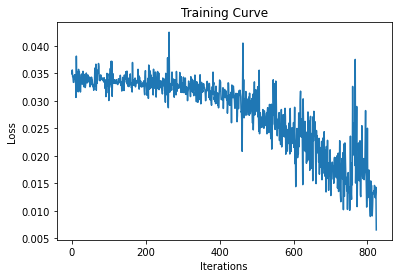

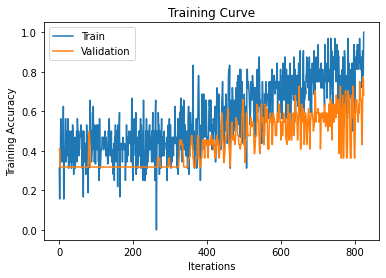

Epoch:  25 Train Accuracy:  0.8689320388349514 Val Accuracy:  0.5909090909090909 Progress:  34.67  % Time Elapsed:  1519.20 s 
Epoch 25 Finished.  Time per Epoch:  58.43 s 
Epoch:  26 Train Accuracy:  0.8669902912621359 Val Accuracy:  0.7272727272727273 Progress:  36.00  % Time Elapsed:  1570.16 s 
Epoch 26 Finished.  Time per Epoch:  58.15 s 
Epoch:  27 Train Accuracy:  0.9339805825242719 Val Accuracy:  0.7045454545454546 Progress:  37.33  % Time Elapsed:  1621.47 s 
Epoch 27 Finished.  Time per Epoch:  57.91 s 
Epoch:  28 Train Accuracy:  0.9087378640776699 Val Accuracy:  0.7727272727272727 Progress:  38.67  % Time Elapsed:  1672.73 s 
Epoch 28 Finished.  Time per Epoch:  57.68 s 
Epoch:  29 Train Accuracy:  0.9213592233009709 Val Accuracy:  0.6590909090909091 Progress:  40.00  % Time Elapsed:  1723.98 s 
Epoch 29 Finished.  Time per Epoch:  57.47 s 
Epoch:  30 Train Accuracy:  0.9436893203883495 Val Accuracy:  0.75 Progress:  41.33  % Time Elapsed:  1775.43 s 
Epoch 30 Finished.  Ti

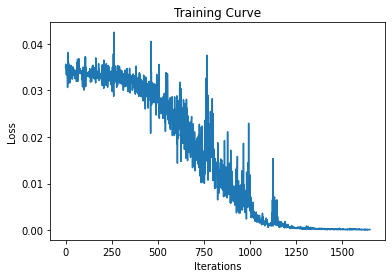

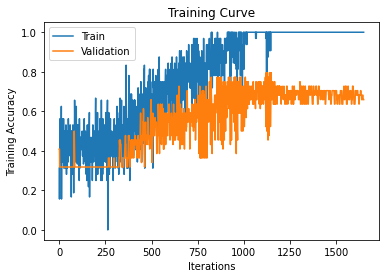

Epoch:  50 Train Accuracy:  1.0 Val Accuracy:  0.6590909090909091 Progress:  68.00  % Time Elapsed:  2804.14 s 
Epoch 50 Finished.  Time per Epoch:  54.98 s 
Epoch:  51 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  69.33  % Time Elapsed:  2853.83 s 
Epoch 51 Finished.  Time per Epoch:  54.88 s 
Epoch:  52 Train Accuracy:  1.0 Val Accuracy:  0.6590909090909091 Progress:  70.67  % Time Elapsed:  2903.67 s 
Epoch 52 Finished.  Time per Epoch:  54.79 s 
Epoch:  53 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  72.00  % Time Elapsed:  2952.58 s 
Epoch 53 Finished.  Time per Epoch:  54.68 s 
Epoch:  54 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  73.33  % Time Elapsed:  3001.06 s 
Epoch 54 Finished.  Time per Epoch:  54.56 s 
Epoch:  55 Train Accuracy:  1.0 Val Accuracy:  0.6590909090909091 Progress:  74.67  % Time Elapsed:  3050.62 s 
Epoch 55 Finished.  Time per Epoch:  54.48 s 
Epoch:  56 Train Accuracy:  1.0 Val Accuracy:  0.659

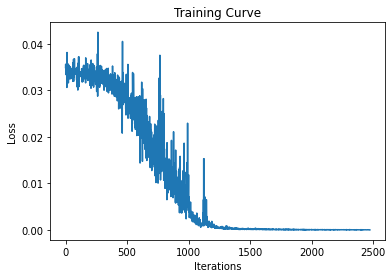

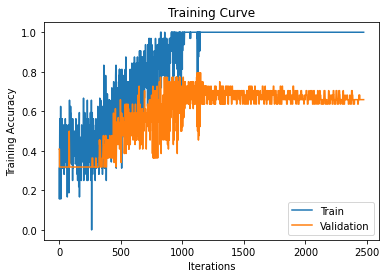

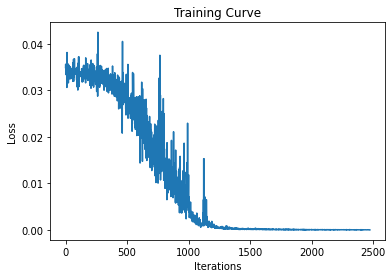

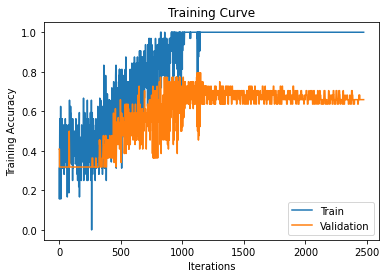

Finished Training
Total time:   3970.00 s  Time per Epoch:  52.93 s 


In [14]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 75
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Baseline Experimentation with 3 classes, image size 224

In [6]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/mfcc_wo_spanish/train', transform=data_transform)
  test_data = [] #test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Librosa_MFCC_Test_Class/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/mfcc_wo_spanish/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


(27, 3, 224, 336)


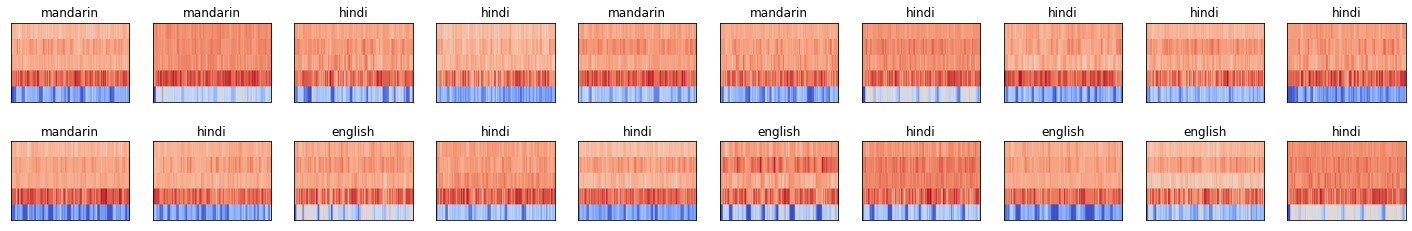

In [7]:
train_data, val_data, test_data= generate_data_image()
visualize_image_data(train_data)

In [20]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.1'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 200)
          self.fc2 = nn.Linear(200, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   1.33  % Time Elapsed:  63.08 s 
Epoch 0 Finished.  Time per Epoch:  63.08 s 
Epoch:  1 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   2.67  % Time Elapsed:  125.15 s 
Epoch 1 Finished.  Time per Epoch:  62.57 s 
Epoch:  2 Train Accuracy:  0.45922330097087377 Val Accuracy:  0.3181818181818182 Progress:   4.00  % Time Elapsed:  186.98 s 
Epoch 2 Finished.  Time per Epoch:  62.33 s 
Epoch:  3 Train Accuracy:  0.4349514563106796 Val Accuracy:  0.3409090909090909 Progress:   5.33  % Time Elapsed:  250.61 s 
Epoch 3 Finished.  Time per Epoch:  62.65 s 
Epoch:  4 Train Accuracy:  0.48058252427184467 Val Accuracy:  0.3181818181818182 Progress:   6.67  % Time Elapsed:  312.16 s 
Epoch 4 Finished.  Time per Epoch:  62.43 s 
Epoch:  5 Train Accuracy:  0.5106796116504855 Val Accuracy:  0.45454545454545453 Progress:   8.00  % Time Elapsed:  373.71 s 
Epoch 5 Fi

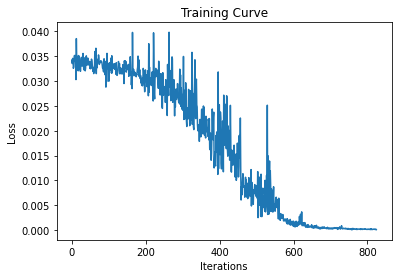

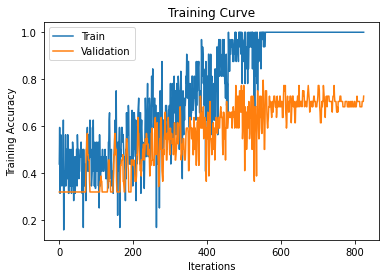

Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  34.67  % Time Elapsed:  1581.80 s 
Epoch 25 Finished.  Time per Epoch:  60.84 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  36.00  % Time Elapsed:  1642.02 s 
Epoch 26 Finished.  Time per Epoch:  60.82 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  37.33  % Time Elapsed:  1702.07 s 
Epoch 27 Finished.  Time per Epoch:  60.79 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  38.67  % Time Elapsed:  1762.01 s 
Epoch 28 Finished.  Time per Epoch:  60.76 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  40.00  % Time Elapsed:  1822.63 s 
Epoch 29 Finished.  Time per Epoch:  60.75 s 
Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  41.33  % Time Elapsed:  1882.66 s 
Epoch 30 Finished.  Time per Epoch:  60.73 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.704

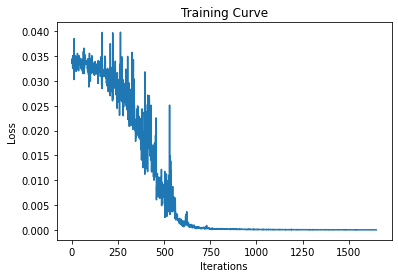

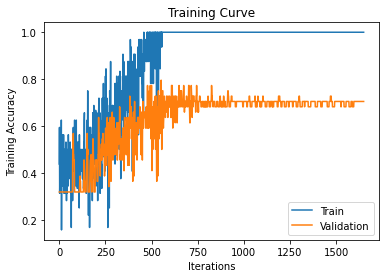

Epoch:  50 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  68.00  % Time Elapsed:  3075.96 s 
Epoch 50 Finished.  Time per Epoch:  60.31 s 
Epoch:  51 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  69.33  % Time Elapsed:  3135.49 s 
Epoch 51 Finished.  Time per Epoch:  60.30 s 
Epoch:  52 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  70.67  % Time Elapsed:  3195.10 s 
Epoch 52 Finished.  Time per Epoch:  60.28 s 
Epoch:  53 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  72.00  % Time Elapsed:  3254.74 s 
Epoch 53 Finished.  Time per Epoch:  60.27 s 
Epoch:  54 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  73.33  % Time Elapsed:  3313.93 s 
Epoch 54 Finished.  Time per Epoch:  60.25 s 
Epoch:  55 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  74.67  % Time Elapsed:  3373.67 s 
Epoch 55 Finished.  Time per Epoch:  60.24 s 
Epoch:  56 Train Accuracy:  1.0 Val Accuracy:  0.681

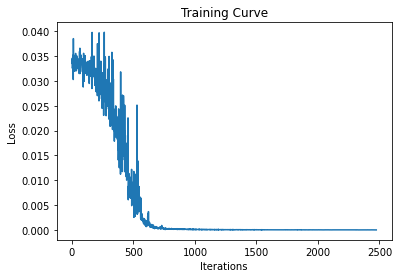

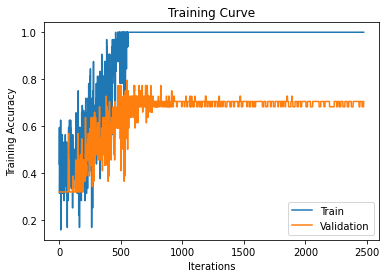

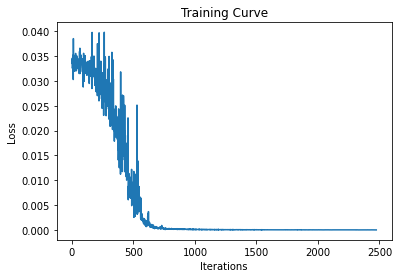

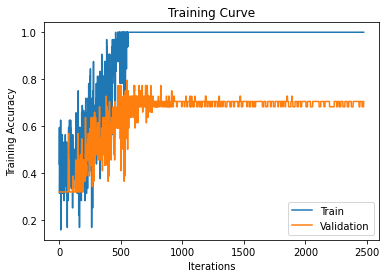

Finished Training
Total time:   4507.43 s  Time per Epoch:  60.10 s 


In [21]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 75
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Reducing Hidden Units in fc, image size 224

In [23]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.2'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 64)
          self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   2.00  % Time Elapsed:  61.32 s 
Epoch 0 Finished.  Time per Epoch:  61.32 s 
Epoch:  1 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   4.00  % Time Elapsed:  121.59 s 
Epoch 1 Finished.  Time per Epoch:  60.79 s 
Epoch:  2 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   6.00  % Time Elapsed:  181.80 s 
Epoch 2 Finished.  Time per Epoch:  60.60 s 
Epoch:  3 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   8.00  % Time Elapsed:  242.25 s 
Epoch 3 Finished.  Time per Epoch:  60.56 s 
Epoch:  4 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  10.00  % Time Elapsed:  302.48 s 
Epoch 4 Finished.  Time per Epoch:  60.50 s 
Epoch:  5 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  12.00  % Time Elapsed:  362.48 s 
Epoch 5 F

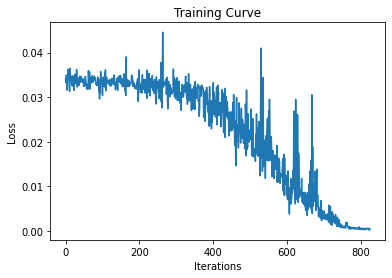

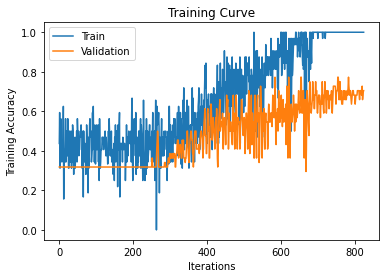

Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  52.00  % Time Elapsed:  1567.16 s 
Epoch 25 Finished.  Time per Epoch:  60.28 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  54.00  % Time Elapsed:  1627.22 s 
Epoch 26 Finished.  Time per Epoch:  60.27 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  56.00  % Time Elapsed:  1687.17 s 
Epoch 27 Finished.  Time per Epoch:  60.26 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  58.00  % Time Elapsed:  1747.30 s 
Epoch 28 Finished.  Time per Epoch:  60.25 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  60.00  % Time Elapsed:  1807.95 s 
Epoch 29 Finished.  Time per Epoch:  60.27 s 
Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.6818181818181818 Progress:  62.00  % Time Elapsed:  1867.94 s 
Epoch 30 Finished.  Time per Epoch:  60.26 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.681

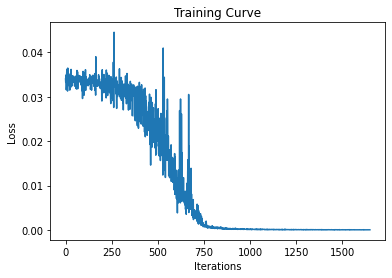

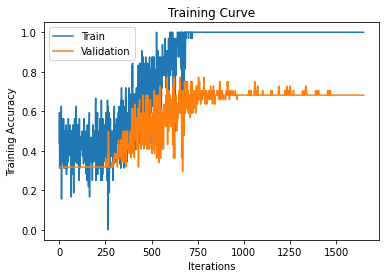

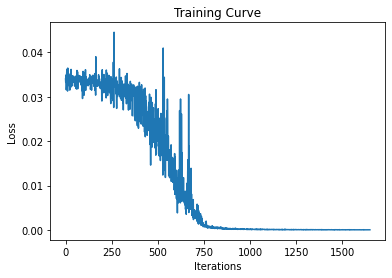

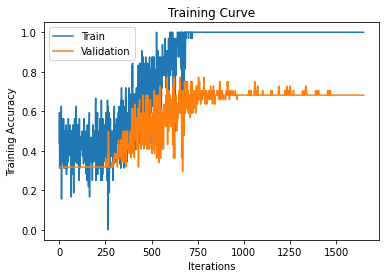

Finished Training
Total time:   3010.06 s  Time per Epoch:  60.20 s 


In [24]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 50
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Increasing Hidden Units in fc, image size 224

In [25]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.3'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 512)
          self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.40485436893203886 Val Accuracy:  0.3181818181818182 Progress:   2.86  % Time Elapsed:  61.90 s 
Epoch 0 Finished.  Time per Epoch:  61.90 s 
Epoch:  1 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   5.71  % Time Elapsed:  122.42 s 
Epoch 1 Finished.  Time per Epoch:  61.21 s 
Epoch:  2 Train Accuracy:  0.4320388349514563 Val Accuracy:  0.3181818181818182 Progress:   8.57  % Time Elapsed:  182.60 s 
Epoch 2 Finished.  Time per Epoch:  60.87 s 
Epoch:  3 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  11.43  % Time Elapsed:  242.74 s 
Epoch 3 Finished.  Time per Epoch:  60.69 s 
Epoch:  4 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  14.29  % Time Elapsed:  303.39 s 
Epoch 4 Finished.  Time per Epoch:  60.68 s 
Epoch:  5 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  17.14  % Time Elapsed:  363.80 s 
Epoch 5 Fi

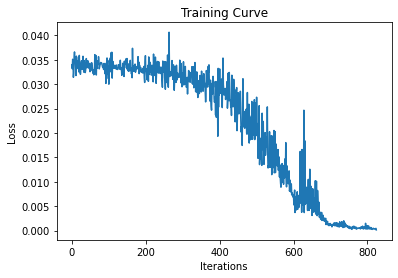

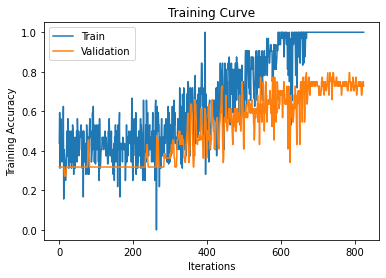

Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  74.29  % Time Elapsed:  1576.80 s 
Epoch 25 Finished.  Time per Epoch:  60.65 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  77.14  % Time Elapsed:  1639.42 s 
Epoch 26 Finished.  Time per Epoch:  60.72 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  80.00  % Time Elapsed:  1702.03 s 
Epoch 27 Finished.  Time per Epoch:  60.79 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  82.86  % Time Elapsed:  1764.64 s 
Epoch 28 Finished.  Time per Epoch:  60.85 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  85.71  % Time Elapsed:  1827.31 s 
Epoch 29 Finished.  Time per Epoch:  60.91 s 
Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.7272727272727273 Progress:  88.57  % Time Elapsed:  1890.58 s 
Epoch 30 Finished.  Time per Epoch:  60.99 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.727

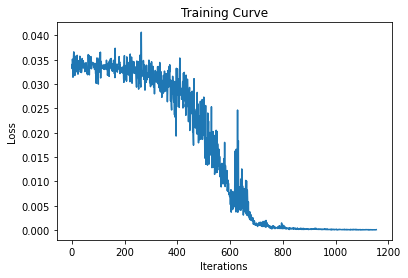

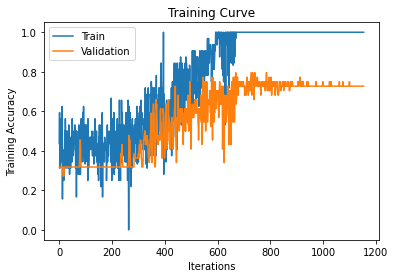

Finished Training
Total time:   2141.15 s  Time per Epoch:  61.18 s 


In [26]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 35
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

Adding Drop Out 

In [8]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.4'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 512)
          self.fc2 = nn.Linear(512, 3)
          self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.39611650485436894 Val Accuracy:  0.3181818181818182 Progress:   2.86  % Time Elapsed:  169.87 s 
Epoch 0 Finished.  Time per Epoch:  169.87 s 
Epoch:  1 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:   5.71  % Time Elapsed:  261.85 s 
Epoch 1 Finished.  Time per Epoch:  130.92 s 
Epoch:  2 Train Accuracy:  0.43786407766990293 Val Accuracy:  0.3181818181818182 Progress:   8.57  % Time Elapsed:  355.48 s 
Epoch 2 Finished.  Time per Epoch:  118.49 s 
Epoch:  3 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  11.43  % Time Elapsed:  449.74 s 
Epoch 3 Finished.  Time per Epoch:  112.44 s 
Epoch:  4 Train Accuracy:  0.42718446601941745 Val Accuracy:  0.3181818181818182 Progress:  14.29  % Time Elapsed:  543.55 s 
Epoch 4 Finished.  Time per Epoch:  108.71 s 
Epoch:  5 Train Accuracy:  0.4388349514563107 Val Accuracy:  0.3181818181818182 Progress:  17.14  % Time Elapsed:  636.64 s 
Epoc

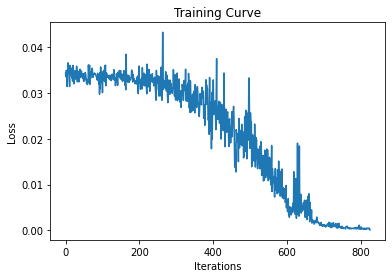

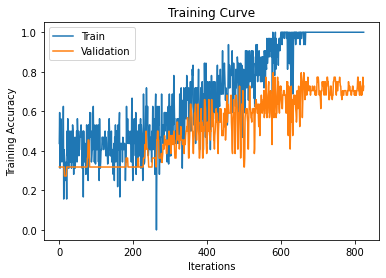

Epoch:  25 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  74.29  % Time Elapsed:  2471.32 s 
Epoch 25 Finished.  Time per Epoch:  95.05 s 
Epoch:  26 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  77.14  % Time Elapsed:  2561.52 s 
Epoch 26 Finished.  Time per Epoch:  94.87 s 
Epoch:  27 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  80.00  % Time Elapsed:  2653.50 s 
Epoch 27 Finished.  Time per Epoch:  94.77 s 
Epoch:  28 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  82.86  % Time Elapsed:  2742.60 s 
Epoch 28 Finished.  Time per Epoch:  94.57 s 
Epoch:  29 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  85.71  % Time Elapsed:  2828.29 s 
Epoch 29 Finished.  Time per Epoch:  94.28 s 
Epoch:  30 Train Accuracy:  1.0 Val Accuracy:  0.7045454545454546 Progress:  88.57  % Time Elapsed:  2918.91 s 
Epoch 30 Finished.  Time per Epoch:  94.16 s 
Epoch:  31 Train Accuracy:  1.0 Val Accuracy:  0.704

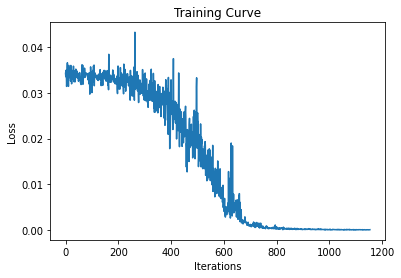

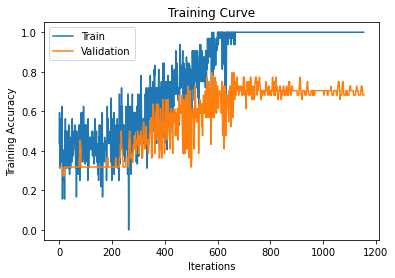

Finished Training
Total time:   3292.89 s  Time per Epoch:  94.08 s 


In [11]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 35
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)